In [ ]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
PATH_TO_PROJECT = '/content/gdrive/MyDrive/DSFProject'

In [ ]:
%cd -q $PATH_TO_PROJECT

In [ ]:
!ls

DSF_Project.ipynb  jokes.csv  one-million-reddit-jokes.csv


In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm
df = pd.read_csv('one-million-reddit-jokes.csv')

print(df.info())
print(df.head())

In [ ]:
columns_with_removed = {}

for column in df.columns:
    if df[column].astype(str).str.contains(r'\[removed\]', na=False).any():
        count = df[column].astype(str).str.contains(r'\[removed\]', na=False).sum()
        columns_with_removed[column] = count

for column, count in columns_with_removed.items():
    print(f"Column '{column}' contains '[removed]' in {count} rows.")

NameError: name 'df' is not defined

In [ ]:
df_cleaned = df[~df['selftext'].str.contains(r'\[removed\]', na=False) & ~df['title'].str.contains(r'\[removed\]', na=False)].copy()

df_cleaned.reset_index(drop=True, inplace=True)
print(f"Number of entries after cleaning: {len(df_cleaned)}")

df_cleaned.to_csv('jokes.csv', index=False)

In [ ]:
!ls

In [ ]:
df = pd.read_csv('jokes.csv')

print(df.info())
print(df.head())

df['text'] = df['title'] + ' ' + df['selftext'].fillna('')
df = df.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163778 entries, 0 to 163777
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   type            163778 non-null  object
 1   id              163778 non-null  object
 2   subreddit.id    163778 non-null  object
 3   subreddit.name  163778 non-null  object
 4   subreddit.nsfw  163778 non-null  bool  
 5   created_utc     163778 non-null  int64 
 6   permalink       163778 non-null  object
 7   domain          163778 non-null  object
 8   url             1052 non-null    object
 9   selftext        162716 non-null  object
 10  title           163778 non-null  object
 11  score           163778 non-null  int64 
dtypes: bool(1), int64(2), object(9)
memory usage: 13.9+ MB
None
   type      id subreddit.id subreddit.name  subreddit.nsfw  created_utc  \
0  post  ftbp1i        2qh72          jokes           False   1585785543   
1  post  ftboup        2qh72          joke

In [ ]:
threshold = df['score'].median()
df['label'] = np.where(df['score'] >= threshold, 1, 0)  # 1 for 'funny', 0 for 'not funny'
# Initializing the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class JokesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [ ]:
train_dataset = JokesDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = JokesDataset(val_texts, val_labels, tokenizer, max_len=128)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()

In [ ]:
for epoch in range(3):  # Number of epochs
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} completed. Average training loss: {avg_train_loss:.4f}')

# Evaluation on validation set
model.eval()
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)
accuracy = correct_predictions.double() / total_predictions
print(f'Validation Accuracy: {accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 8189/8189 [46:40<00:00,  2.92it/s]


Epoch 1 completed. Average training loss: 0.6369


Training Epoch 2: 100%|██████████| 8189/8189 [46:43<00:00,  2.92it/s]


Epoch 2 completed. Average training loss: 0.5689


Training Epoch 3: 100%|██████████| 8189/8189 [46:43<00:00,  2.92it/s]


Epoch 3 completed. Average training loss: 0.4312


Evaluating: 100%|██████████| 2048/2048 [03:55<00:00,  8.70it/s]

Validation Accuracy: 0.6388


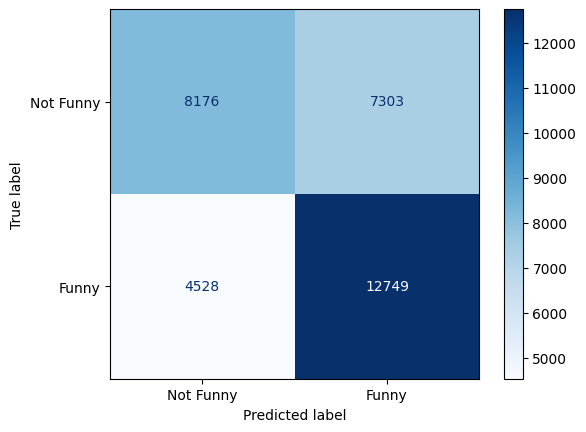

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].cpu().numpy()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Funny", "Funny"])
disp.plot(cmap='Blues')


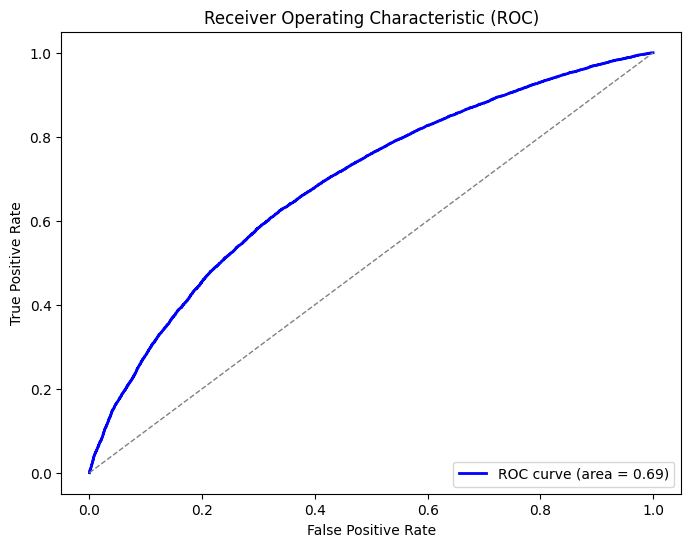

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probs = []
true_labels = []
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].cpu().numpy()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())
        true_labels.extend(labels)

fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
